## Setup

**Import Statements**

In [186]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import sleep
from sklearn.metrics import r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from amb_sdk.sdk import DarwinSdk

**Connection to Darwin**

In [187]:
# Login
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('skenkare@austin.rr.com', 'C9ZcJp32Ze')

if not status:
    print(msg)


**Setup Path**

In [188]:
path = './sets/'

## Upload and Read Data

**Read Data**

In [190]:
dataset_name = 'remittances_data.csv'
df = pd.read_csv(os.path.join(path, dataset_name))
df.head()
target = "speed actual"


/home/skenkare/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
target = "speed actual"

speed_actual_column = df[target]

#replace NaNs
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df = imp.fit_transform(df)

#fix columns with one hot encoding
ohe = OneHotEncoder(handle_unknown='ignore')
df.reshape(1, -1)
df = ohe.fit_transform(df)

#remove columns with low variance
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
df = selector.fit_transform(df)

#write to csv
df = pd.DataFrame(df.toarray())
df["speed_actual"] = speed_actual_column
df.to_csv("./sets/feature_selected.csv")

**Upload to Darwin**

In [176]:
# Upload dataset, using corrected values
dataset_name = "feature_selected.csv"
status, message = ds.delete_dataset(dataset_name)
status, dataset = ds.upload_dataset(os.path.join(path, dataset_name))
if not status:
    print(dataset)

## Clean Data

In [181]:
# clean dataset
target = "speed_actual"
status, job_id = ds.clean_data(dataset_name, target=target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    


{'status': 'Requested', 'starttime': '2019-04-22T09:10:38.213662', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['feature_selected.csv'], 'artifact_names': ['29f56d63e0814a52b79afac917c46fda'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-22T09:10:38.213662', 'endtime': '2019-04-22T09:10:44.121322', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['feature_selected.csv'], 'artifact_names': ['29f56d63e0814a52b79afac917c46fda'], 'model_name': None, 'job_error': ''}


## Create and Train Model

In [185]:
model = target + "_model1"
ds.delete_model(model)
status, job_id = ds.create_model(dataset_names = dataset_name, \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-22T09:19:43.715248', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['feature_selected.csv'], 'artifact_names': None, 'model_name': 'speed_actual_model1', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-22T09:19:43.715248', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['feature_selected.csv'], 'artifact_names': None, 'model_name': 'speed_actual_model1', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T09:19:43.715248', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['feature_selected.csv'], 'artifact_names': None, 'model_name': 'speed_actual_model1', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-22T09:19:43.715248', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None,

## Analyze Data

In [93]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-21T16:16:20.222567', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 1.2975388765335083, 'generations': 7, 'dataset_names': None, 'artifact_names': ['72264dc5397b4407a0596f55696f3a81'], 'model_name': 'speed_actual_model1', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-21T16:16:20.222567', 'endtime': '2019-04-21T16:16:23.362772', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 1.2975388765335083, 'generations': 7, 'dataset_names': None, 'artifact_names': ['72264dc5397b4407a0596f55696f3a81'], 'model_name': 'speed_actual_model1', 'job_error': ''}


In [94]:
feature_importance[:10]

15 = 1.0      0.410305
Unnamed: 0    0.091621
11 = 1.0      0.089349
10 = 1.0      0.058349
13 = 1.0      0.033356
12 = 1.0      0.030955
22 = 1.0      0.026578
3 = 1.0       0.026189
23 = 1.0      0.020813
7 = 1.0       0.019945
dtype: float64

**Model Prediction**

In [95]:
status, artifact = ds.run_model(dataset_name, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2019-04-21T16:17:38.32746', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 1.2975388765335083, 'generations': 7, 'dataset_names': ['feature_selected.csv'], 'artifact_names': ['31d5383faa314cf28b8800a68b693889'], 'model_name': 'speed_actual_model1', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-21T16:17:38.32746', 'endtime': '2019-04-21T16:17:40.453964', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 1.2975388765335083, 'generations': 7, 'dataset_names': ['feature_selected.csv'], 'artifact_names': ['31d5383faa314cf28b8800a68b693889'], 'model_name': 'speed_actual_model1', 'job_error': ''}


(True, 'Job completed')

**Get Predictions from Darwin**

In [96]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
#print(prediction)
prediction.head()

,prob_2 days,prob_3-5 days,prob_6 days or more,prob_Less than one hour,prob_Next day,prob_Same day,speed_actual
0,0.000087,0.000082,0.000336,0.999298,0.000105,0.000093,Less than one hour
1,0.171699,0.103797,0.002149,0.001470,0.304412,0.416473,Same day
2,0.339851,0.273678,0.056500,0.004455,0.269343,0.056173,2 days
3,0.000087,0.000082,0.000092,0.999539,0.000107,0.000093,Less than one hour
4,0.000087,0.000082,0.000092,0.999539,0.000107,0.000093,Less than one hour


45748


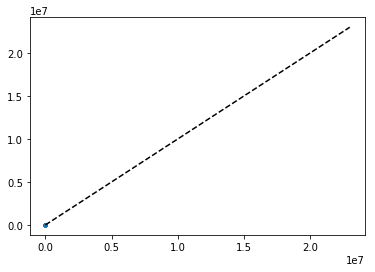

R^2 :  0.7624481478976393


In [97]:
#Plot predictions vs actual
print(len(prediction[target]))

#Encode all values so that it can be graphed, needs numbers
prediction[target] = prediction[target].replace('Less than one hour', 0)
df[target] = df[target].replace('Less than one hour', 0)
prediction[target] = prediction[target].replace('Same day', 1)
df[target] = df[target].replace('Same day', 1)
prediction[target] = prediction[target].replace('Next day', 2)
df[target] = df[target].replace('Next day', 2)
prediction[target] = prediction[target].replace('2 days', 3)
df[target] = df[target].replace('2 days', 3)
prediction[target] = prediction[target].replace('3-5 days', 4)
df[target] = df[target].replace('3-5 days', 4)
prediction[target] = prediction[target].replace('6 days or more', 5)
df[target] = df[target].replace('6 days or more', 5)
plt.plot(df[target], prediction[target], '.')
plt.plot([0,2.3e7],[0,2.3e7],'--k')
plt.show()
print('R^2 : ', r2_score(df[target], prediction[target]))